# **Deep Learning Project**

## **Mammal Species Image Classification**

## **Overview**

This project involves building a deep learning model to classify images of different mammal species.

# **Importing Dataset**

For Dataset, let's connect with Kaggle API to get the data download from there directy

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d asaniczka/mammals-image-classification-dataset-45-animals

 89% 165M/185M [00:01<00:00, 142MB/s]
100% 185M/185M [00:01<00:00, 136MB/s]


In [3]:
#unzipping files
import zipfile
zip_ref = zipfile.ZipFile('/content/mammals-image-classification-dataset-45-animals.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 9.9 MB

In [12]:
!pip install pydantic

In [15]:
!pip install --upgrade huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4


In [3]:
# Import necessary libraries
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image



# **Data Preprocessing**

Before training our deep learning model, it is essential to preprocess the data. This process includes several key steps:

1. **Normalization**: We rescale the pixel values in the images from a range of 0-255 to 0-1. This normalization helps in speeding up the training process and reducing the chance of overfitting.

2. **Image Resizing**: We resize all images to a uniform size of 256x256 pixels. This uniformity is necessary because the input layer of our neural network expects images of the same size.

3. **Data Splitting**: The dataset is split into training and validation subsets. We use 80% of the data for training and 20% for validation. This separation helps in evaluating the model's performance on unseen data.

4. **Categorical Labels**: Since this is a multi-class classification problem, we set the `class_mode` to 'categorical', which means our labels will be one-hot encoded.

The `ImageDataGenerator` class in Keras makes these preprocessing steps efficient and easy to implement.

In [ ]:
# Data Preprocessing
def preprocess_data(data_dir, img_size=(256, 256), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

    return train_generator, validation_generator

# **Model Development**

Building an effective deep learning model involves defining its architecture and compiling it with appropriate settings:

1. **Model Architecture**: We use a base model (which can be a pre-trained model like VGG16 or ResNet) followed by global average pooling and dense layers. The global average pooling layer simplifies the output of the base model, and the dense layers are used for classification.

2. **Output Layer**: The final dense layer has a softmax activation function with the number of units equal to the number of classes (45 in this case). Softmax is used because it's a multi-class classification problem.

3. **Compilation**: We compile the model using the Adam optimizer with a learning rate of 0.0001. The loss function used is 'categorical_crossentropy', which is standard for multi-class classification tasks. We also monitor the 'accuracy' metric to evaluate our model.

These steps form the core of our model, which will be trained to classify different mammal species.

In [ ]:
# Model Development
def build_model(base_model, num_classes):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Loading the Dataset

To train and validate our model, we load the dataset from the specified directory. We have a total of 45 classes of mammals, and we use our `preprocess_data` function to prepare our data. This function returns two generators: one for training and one for validation. These generators will be used to feed data into our model during the training process.


In [5]:
# Load the dataset
data_dir = '/content/mammals'
num_classes = 45
train_gen, val_gen = preprocess_data(data_dir, img_size=(256, 256), batch_size=32)


Found 11020 images belonging to 45 classes.
Found 2731 images belonging to 45 classes.


## Visualizing Sample Images

It's important to visually inspect some of the images from our dataset. This helps us understand the kind of data we are working with and ensures that the images are being loaded and preprocessed correctly.

1. **Function `plot_images`**: We define a function `plot_images` that takes an array of images and their respective class names. This function plots a specified number of images in a grid format.

2. **Displaying Images**: We use the `plot_images` function to display the first five images from our training dataset. These images give us a glimpse into the variety and quality of the images that our model will learn from.

Visualizing these images is a good practice to confirm that our data preprocessing steps (like resizing and normalization) are being applied correctly.


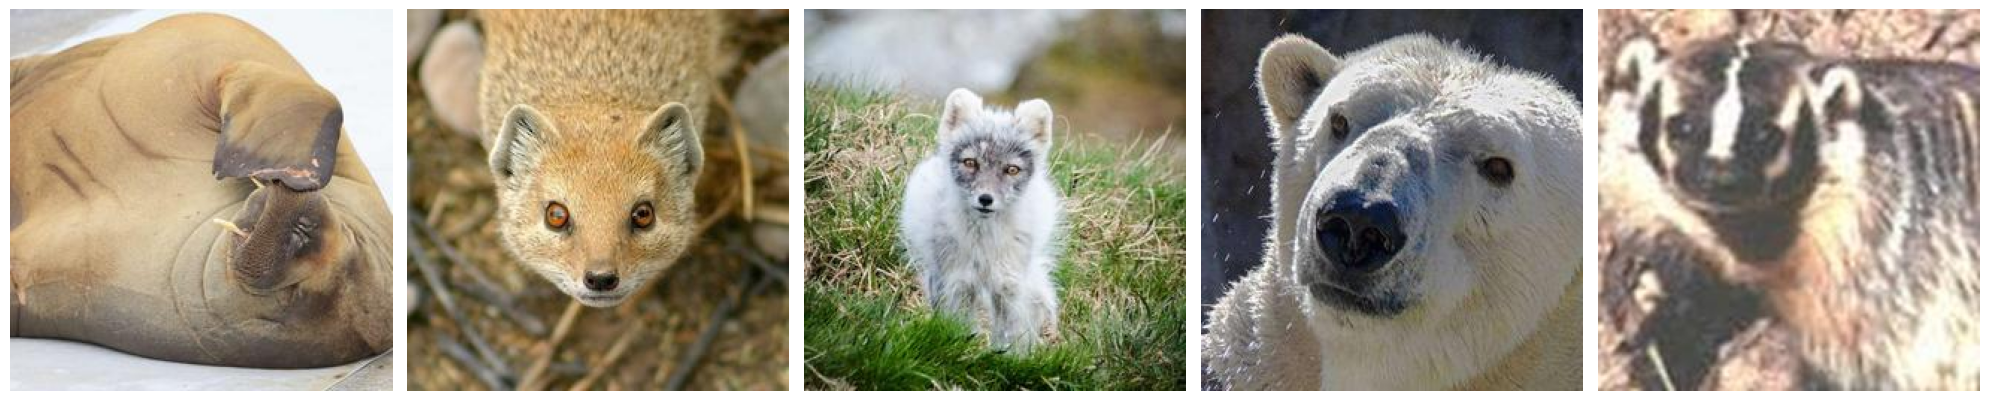

In [10]:
def plot_images(images_arr, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize Sample Images
sample_training_images, _ = next(train_gen)
plot_images(sample_training_images[:5], class_names=train_gen.class_indices)




## Visualizing Class Distribution

Understanding the distribution of classes in our dataset is crucial. An uneven distribution (where some classes have significantly more images than others) can lead to biases in our model, where it performs well on some classes but poorly on others.

1. **Calculating Class Counts**: We calculate the number of images for each class in our training dataset. This gives us an idea of how balanced or imbalanced our dataset is.

2. **Bar Plot for Distribution**: We create a bar plot to visually represent the number of images in each class. This plot helps in quickly identifying if any class is underrepresented or overrepresented in the dataset.

Ensuring a balanced dataset is key to training a model that performs consistently across all classes.


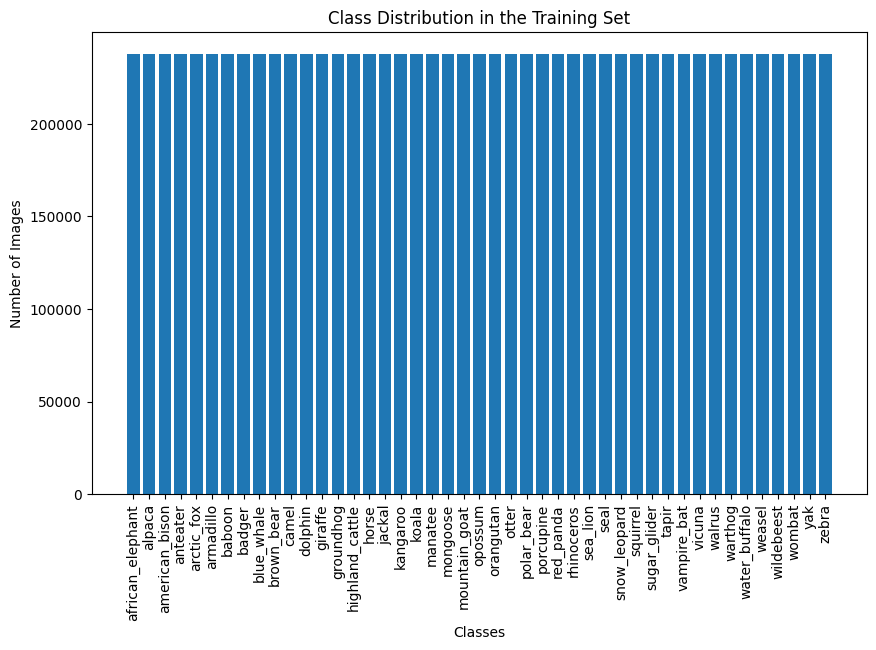

In [11]:
# Class Distribution
class_counts = np.sum(train_gen.labels, axis=0)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.title('Class Distribution in the Training Set')
plt.show()

## Building and Training VGG16 and ResNet50 Models

In this section, we build and train two different convolutional neural network models - VGG16 and ResNet50 - to compare their performance on our mammal species classification task.

### VGG16 Model
1. **Model Architecture**: We use VGG16 as our base model. This model is pre-trained on the ImageNet dataset, giving it a good starting point for feature extraction.
2. **Modifications**: We set `include_top=False` to customize the output layer for our specific number of classes (45). The model's pre-trained layers are set as non-trainable (`trainable = False`) to keep the learned features from ImageNet intact.
3. **Building the Model**: We add global average pooling and dense layers on top of the base model to adapt it to our classification task.

### ResNet50 Model
Similarly, we create a ResNet50 model with the same modifications as VGG16. ResNet50 is another powerful architecture known for its deep layers and residual connections, making it effective for a wide range of image classification tasks.

### Model Checkpoints
We use callbacks to save the best version of each model based on validation accuracy. This approach ensures that we retain the model at its peak performance during training.

### Training the Models
Both models are trained for 10 epochs. We use the training and validation generators to supply the data. During training, the models learn to classify images into one of the 45 mammal species.

By training both models, we can compare their effectiveness and select the best one for our classification task.


In [6]:
# VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_vgg.trainable = False
model_vgg = build_model(base_model_vgg, num_classes)

# ResNet50 Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_resnet.trainable = False
model_resnet = build_model(base_model_resnet, num_classes)

# Callbacks for saving the best model
checkpoint_vgg = ModelCheckpoint('vgg_best_model.h5', monitor='val_accuracy', save_best_only=True)
checkpoint_resnet = ModelCheckpoint('resnet_best_model.h5', monitor='val_accuracy', save_best_only=True)

# Training the models
history_vgg = model_vgg.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[checkpoint_vgg])
history_resnet = model_resnet.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[checkpoint_resnet])

58889256/58889256 [==============================] - 0s 0us/step


94765736/94765736 [==============================] - 1s 0us/step


Epoch 1/10
345/345 [==============================] - 90s 231ms/step - loss: 2.6220 - accuracy: 0.3372 - val_loss: 1.8297 - val_accuracy: 0.5185
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


345/345 [==============================] - 75s 218ms/step - loss: 1.5725 - accuracy: 0.5797 - val_loss: 1.4307 - val_accuracy: 0.6078
Epoch 3/10
345/345 [==============================] - 75s 218ms/step - loss: 1.2394 - accuracy: 0.6605 - val_loss: 1.2141 - val_accuracy: 0.6639
Epoch 4/10
345/345 [==============================] - 81s 235ms/step - loss: 1.0615 - accuracy: 0.7032 - val_loss: 1.1212 - val_accuracy: 0.6770
Epoch 5/10
345/345 [==============================] - 76s 219ms/step - loss: 0.9537 - accuracy: 0.7313 - val_loss: 1.0366 - val_accuracy: 0.7019
Epoch 6/10
345/345 [==============================] - 75s 218ms/step - loss: 0.8600 - accuracy: 0.7598 - val_loss: 1.1294 - val_accuracy: 0.6741
Epoch 7/10
345/345 [==============================] - 75s 218ms/step - loss: 0.7874 - accuracy: 0.7774 - val_loss: 1.0075 - val_accuracy: 0.7041
Epoch 8/10
345/345 [==============================] - 75s 218ms/step - loss: 0.7386 - accuracy: 0.7886 - val_loss: 0.9867 - val_accuracy: 0.7

## Plotting Training History

To evaluate and compare the performance of our VGG16 and ResNet50 models, it's important to visualize their training history. This visualization helps us understand how well the models learn over each epoch and if there are issues like overfitting or underfitting.

### Function `plot_history`
1. **Purpose**: We define a function `plot_history` to plot the accuracy and loss for both training and validation phases. This function takes the model's history object and a title as inputs.
2. **Accuracy Plot**: The first subplot shows the training and validation accuracy over each epoch. High training accuracy with lower validation accuracy might indicate overfitting.
3. **Loss Plot**: The second subplot shows the training and validation loss. A significant difference between training and validation loss can also be indicative of overfitting.

### Visualizing Models' Performance
We call the `plot_history` function for both the VGG16 and ResNet50 models. These plots allow us to compare how each model learns and generalizes on the validation data across epochs. They are crucial for understanding the learning dynamics and making informed decisions about model adjustments or early stopping.


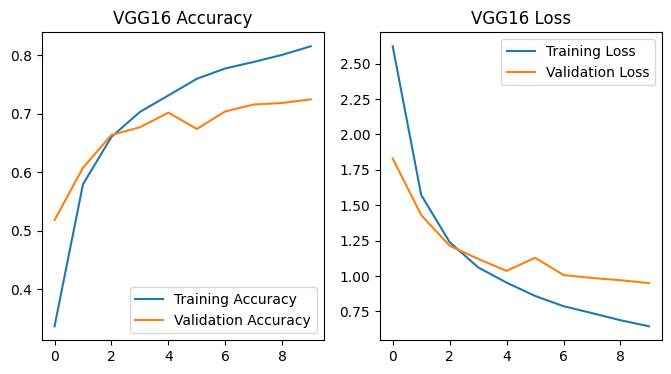

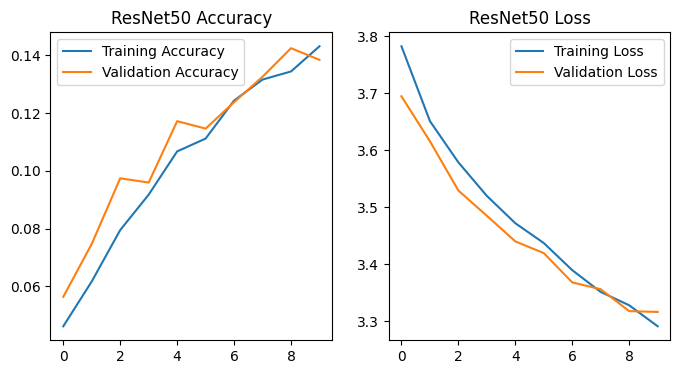

In [7]:
# Function to plot training history
def plot_history(history, title):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + ' Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_history(history_vgg, 'VGG16')
plot_history(history_resnet, 'ResNet50')

## Image Loading, Preprocessing, and Prediction

To make our trained model useful in practical scenarios, we need to set up a way to input new images, preprocess them, and use the model to make predictions.

### Function `load_and_prep_image`
1. **Purpose**: This function prepares any uploaded image for prediction. It's crucial because the model expects input data in the same format as the training data.
2. **Process**: The image is first converted to a numpy array and normalized (scaling pixel values to 0-1). It is then resized to the expected input size (256x256) and a batch dimension is added, as the model expects input in batches.

### Function `classify_image`
1. **Prediction**: This function uses `load_and_prep_image` to preprocess the uploaded image and then uses our trained model to predict the class of the image.
2. **Output**: It returns the name of the class predicted by the model. The `np.argmax` function is used to find the index of the highest prediction score, which is then mapped to the corresponding class name.

### Loading the Trained Model
We load our best VGG16 model saved during training. This model will be used to make predictions in our Gradio interface.

### Class Names
The class names are defined based on the classes present in our training data. These names are used to make the predictions human-readable.

### Creating a Gradio Interface
We use Gradio to create an interactive interface for our image classification model. This interface allows users to upload images and see the model's predictions in a user-friendly way.

By launching this Gradio app, we provide an easy way to demonstrate the capabilities of our model in classifying different mammal species.


In [9]:
# Function to load and preprocess the image
def load_and_prep_image(image, img_shape=256):
    # Convert the image to a numpy array and scale the pixel values
    image = np.array(image) / 255.0
    # Resize the image
    image = tf.image.resize(image, [img_shape, img_shape])
    # Add an extra dimension for batch size
    image = np.expand_dims(image, axis=0)
    return image

# Function to make a prediction
def classify_image(uploaded_image):
    img = load_and_prep_image(uploaded_image)
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    return class_names[pred_class]

# Load your trained VGG16 model
model = load_model('/content/vgg_best_model.h5')

# Define the class names
class_names = list(train_gen.class_indices.keys())

# Create a Gradio interface
iface = gr.Interface(fn=classify_image,
                     inputs=gr.Image(),
                     outputs="text",
                     title="Mammal Species Image Classification",
                     description="Upload an image of a mammal and the model will predict its species.")

iface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://1f640b73d1ab4ec973.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 34ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1f640b73d1ab4ec973.gradio.live
